## Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred

show all rows of the dataframe

## Data Acqusition

#### S&P500 (used in stage 1 Kmeans)

S&P 500 data and three months' rolling drawdown calculation.

In [20]:
sp = yf.download("^GSPC", start="2000-01-01", end="2025-03-31", interval="1d") # ^GSPC is the ticker symbol for the S&P 500 Index on Yahoo Finance.
sp_close = sp['Close'].dropna()

/var/folders/w1/22sptr3x2_l_tfpctnng_2xm0000gn/T/ipykernel_57854/3023441979.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2000-01-01", end="2025-03-31", interval="1d") # ^GSPC is the ticker symbol for the S&P 500 Index on Yahoo Finance.
[*********************100%***********************]  1 of 1 completed


The formula for calculating RollingDrawdown based on S&P 500 data:

$$RollingDrawdown(t) = \dfrac{P_t - \max_{t-63 \le s \le t} P_s}{\max_{t-63 \le s \le t} P_s}$$

In [22]:
# Compute rolling 3-month (≈63 trading days) peak 
window = 63  # ~3 months of trading days
rolling_peak = sp_close.rolling(window=window, min_periods=1).max()
rolling_dd = (sp_close - rolling_peak) / rolling_peak   # this will be 0 at local peaks, negative otherwise
rolling_dd_=rolling_dd.dropna()

monthly_rolling_dd = rolling_dd.resample('M').min() # Downsample to monthly to make a cleaner plot like Exhibit 2 in page 5
    # We take the MIN within each month because drawdown is about worst pain

/var/folders/w1/22sptr3x2_l_tfpctnng_2xm0000gn/T/ipykernel_57854/1186798860.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rolling_dd = rolling_dd.resample('M').min() # Downsample to monthly to make a cleaner plot like Exhibit 2 in page 5


S&P 500 Three-Month Rolling Drawdown(EXHITBIT 2 of the paper)

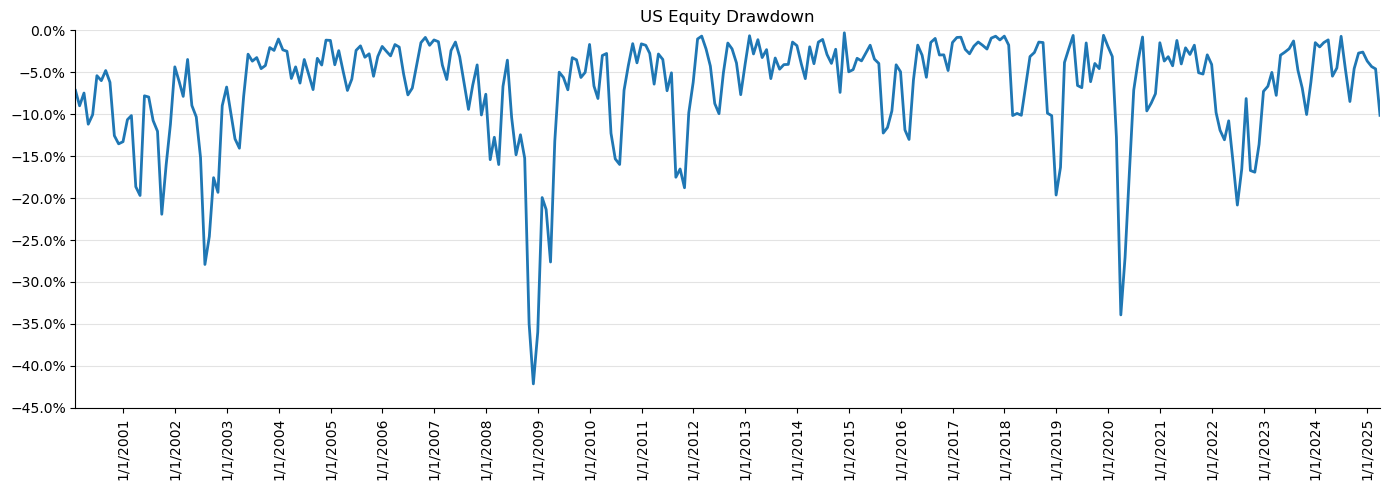

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, MultipleLocator

# --- get a Series and fix the index type ---
s = monthly_rolling_dd.iloc[:, 0].copy()        # pick the ^GSPC column as a Series
s.index = pd.to_datetime(s.index)                # ensure DatetimeIndex
try:
    s.index = s.index.tz_convert(None)           # if tz-aware, drop tz
except Exception:
    pass
s = s.sort_index()

# --- plot ---
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(s.index, s.values, lw=2)

ax.set_title('US Equity Drawdown')
ax.set_xlabel(''); ax.set_ylabel('')

# Y-axis
ax.set_ylim(-0.45, 0)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(True, axis='y', alpha=0.35)

# --- x-axis: yearly ticks on Jan 1, formatted like pic 1 ---
ax.set_xlim(s.index.min(), s.index.max())       # IMPORTANT: clamp to your data range
ax.xaxis.set_major_locator(mdates.YearLocator())  # one tick per year
# show as 1/1/YYYY to mimic the reference chart
try:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('1/1/%Y'))   # mac/linux ok
except ValueError:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('01/01/%Y')) # windows

ax.tick_params(axis='x', labelrotation=90)

# clean frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


#### (Imcomplete) (EXHIBIT 3) Macroeconomic and Financial Market Factors Considered for Machine Learning Testing



EXHIBIT 3 in page 6
**Macroeconomic and Financial Market Factors Considered for Machine Learning Testing**

| **Factors** | **Rationale** | **Variables Considered for Machine Learning Testing** |
|--------------|---------------|-------------------------------------------------------|
| **Inflation** | Inflation can significantly impact factor performance due to its effect on inflation expectations. Inflation can influence interest rates, affecting bond yields and the attractiveness of value-related stocks in comparison to other investments. | - Trailing ten-year annualized changes in core CPI  <br> - Trailing one-year annualized changes in core CPI  <br> **Sources:** FRED, Federal Reserve Economic Data |
| **GDP Growth / Business Cycle** | GDP growth plays a crucial role, as it reflects corporate profit cycles. **During economic expansions, companies tend to experience higher profit growth, and value stocks, which benefit from operating leverage, are more likely to outperform during such periods.** | - US Real GDP Growth  <br> - Conference Board Business Cycle Labels  <br> **Sources:** FRED, Federal Reserve Economic Data |
| **Financial Conditions** | The impact of financial conditions on factor performance is a crucial aspect in the realm of financial markets. Fluctuations in financial conditions, such as interest rates, credit availability, and market volatility, can significantly influence the investment landscape. | - Financial Condition – Risk  <br> - Financial Condition – Credit  <br> - Financial Condition – Leverage  <br> **Sources:** FRED, National Financial Conditions Index |
| **Monetary Policy Expectations** | Policy expectations play a pivotal role in influencing factor performance within financial markets. Anticipation of changes in monetary policy, fiscal measures, or regulatory decisions can significantly impact investor behavior and asset valuations. Factors such as growth, value, and momentum can experience shifts in performance based on policy expectations. | - Effective Federal Funds Rate  <br> - Monetary Policy Expectations  <br> **Sources:** FRED, Federal Reserve Economic Data |
| **Equity Earning Yield** | The equity earning yield significantly influences valuations based on companies’ future earnings expectations. | - Cyclically Adjusted PE Ratio (CAPE Ratio)  <br> **Sources:** Online Data Robert Shiller |


In [ ]:
fred = Fred(api_key='85c8da13d3eae3199354ed65cda60bb8') # fred is an object - an instance of the `Fred` Class # can apply your own api_key on the website, quite easy

##### 1.Inflation

Variables:
- Trailing 10-year annualized changes in core CPI
- Trailing 1-year annualized changes in core CPI
- Source: FRED

In [ ]:
# Core CPI (CPI excluding food and energy)
core_cpi = fred.get_series('CPILFESL')  # Core CPI (Index, 1982-84=100) 

# 1-year annualized change
core_cpi_1y = core_cpi.pct_change(periods=12).dropna()

# 10-year annualized change (120 months)
core_cpi_10y = ((core_cpi / core_cpi.shift(120)) ** (1/10) - 1).dropna()

##### 2. GDP Growth / Business Cycle

Variables:
- US Real GDP growth
- Conference Board Business Cycle Labels
- Sources: FRED + Conference Board

In [28]:
real_gdp = fred.get_series('GDPC1')  # Real GDP (chained dollars)
real_gdp_growth_qoq = real_gdp.pct_change().dropna()  # quarter-over-quarter # might need to convert quarterly -> monthly by foreard filling the same value 
real_gdp_growth_yoy = real_gdp.pct_change(4).dropna() # year-over-year

`!!!attention: we cannot get the Conference Board Business Cycle Labels data yet`

##### 3.Financial Conditions

Variables:
- Financial Condition – Risk
- Financial Condition – Credit
- Financial Condition – Leverage
Source: “FRED, National Financial Conditions Index”

These come from the Chicago Fed’s National Financial Conditions Index (NFCI), which actually has subindexes: Risk, Credit, and Leverage.

In [29]:
nfc_risk = fred.get_series('NFCIRISK')
nfc_credit = fred.get_series('NFCICREDIT')
nfc_leverage = fred.get_series('NFCILEVERAGE')

##### 4.Monetary Policy Expextations 

This one is vague. In practice, people proxy it with:
- Fed Funds futures implied rate,
- OIS curve near-term expectations,
- or Survey-based expectations.

Those are usually not free (they’re from CME futures, Bloomberg, Refinitiv). The paper is almost certainly using some proprietary forward-rate expectation measure.

`Note: cannot access policy expectations so far. `

In [30]:
fed_funds = fred.get_series('FEDFUNDS') # Retrieve Effective Federal Funds Rate (FEDFUNDS)

##### 5.Equity Earning Yield (Incomplete)
Variable:
- Cyclically Adjusted PE Ratio (CAPE Ratio)
- Source: “Online Data Robert Shiller”
Robert Shiller (Yale) publishes this for free (CAPE, earnings yield = 1/CAPE). We can download the Excel/CSV manually from his website and then load with pandas.

#### Six selected equity factors for K means clustering

#### (Incomplete) Financial Turbulance

`Note:`
1. I have not include the returns from various maturity Treasury instruments (12 months, 2 years, and 10 years maturity) data, only calculate it based on 8 secotrs of S&P500 (should be 10, but "XLC", "XLRE" these two feature is too new, so I omit them for the moment.)
2. The general work flow should be the same.

The identification of financial turbulence allows for a deeper understanding of market dynamics and the potential risks associated with market-wide disruptions.  

They measure financial turbulence as:

$$
d_t = (y_t - \mu)' \Sigma^{-1} (y_t - \mu) 
$$

where:

- $d_t$ = turbulence for a particular time period $t$  
- $y_t$ = vector of asset returns for period $t$  
- $\mu$ = sample average vector of historical returns  
- $\Sigma$ = sample covariance matrix of historical returns


|  Ticker  | Sector Name (English)                     | Notes                                       |
| :------: | :---------------------------------------- | :------------------------------------------ |
|  **XLK** | Technology Select Sector SPDR             | Tracks S&P 500 Information Technology Index |
|  **XLF** | Financial Select Sector SPDR              | S&P 500 Financials Index                    |
|  **XLE** | Energy Select Sector SPDR                 | Oil & gas producers, energy equipment       |
|  **XLI** | Industrial Select Sector SPDR             | Transportation, manufacturing, aerospace    |
|  **XLP** | Consumer Staples Select Sector SPDR       | Food, beverages, household goods            |
|  **XLY** | Consumer Discretionary Select Sector SPDR | Retail, automotive, luxury, entertainment   |
|  **XLU** | Utilities Select Sector SPDR              | Electric and gas utilities companies        |
|  **XLB** | Materials Select Sector SPDR              | Chemicals, metals, construction materials   |
|  **XLC** | Communication Services Select Sector SPDR | Telecom & media (e.g. Meta, Alphabet)       |
| **XLRE** | Real Estate Select Sector SPDR            | Real estate investment trusts (REITs)       |


---
- Some comments of this concept:<br>
    - The indicator **Financial turbulence** is actually a kind of **Mahalanobis distance**.<br>
    - Mahalanobis distance measures how many standard deviations a point is from the mean, considering correlations between variables. You can think of it as an oval.
    - It’s essentially the Euclidean distance in a whitened (decorrelated and standardized) space, obtained by using the inverse covariance matrix to rotate and scale the data, making the comparison more objective.

In [32]:
import yfinance as yf
tickers = ["XLK","XLF","XLE","XLI","XLP","XLY","XLU","XLB"]  # exclude "XLC", "XLRE" 
sp_sectors_data = yf.download(tickers, start="2000-01-01", end="2025-10-31", interval="1mo")["Close"]
sp_sectors_returns = sp_sectors_data.pct_change().dropna()


/var/folders/w1/22sptr3x2_l_tfpctnng_2xm0000gn/T/ipykernel_57854/2229220239.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp_sectors_data = yf.download(tickers, start="2000-01-01", end="2025-10-31", interval="1mo")["Close"]
[*********************100%***********************]  8 of 8 completed


In [ ]:
# sp_sectors_data
sp_sectors_returns

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLY
Date,,,,,,,,
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.055716
2000-03-01,0.098287,0.120669,0.178300,0.136861,0.083893,0.034273,0.101030,0.139294
2000-04-01,-0.030926,-0.011625,0.013363,0.016539,-0.091848,0.056400,0.073401,-0.018912
2000-05-01,-0.031557,0.117424,0.022322,-0.004220,-0.103978,0.071329,-0.002194,-0.053980
2000-06-01,-0.089790,-0.059564,-0.051778,-0.041313,0.099557,0.054177,-0.041231,-0.055908
...,...,...,...,...,...,...,...,...
2025-06-01,0.017026,0.040231,0.027669,0.032909,0.096661,-0.022456,-0.003174,0.016511
2025-07-01,0.004178,0.036664,0.003427,0.033573,0.039274,-0.007938,0.056390,0.021032
2025-08-01,0.051864,0.036464,0.030934,0.000000,-0.001104,0.012534,-0.015758,0.046561


In [34]:
print(sp_sectors_returns.isna().sum())

Ticker
XLB    0
XLE    0
XLF    0
XLI    0
XLK    0
XLP    0
XLU    0
XLY    0
dtype: int64


In [35]:
sp_sectors_returns.shape # (309, 8)

(309, 8)

In [36]:
financial_turbulence_returns = sp_sectors_returns.copy() # deep copy
financial_turbulence_mu = financial_turbulence_returns.mean().values 
    # .values change the pandas series to the numpy array
financial_turbulence_inverted_cov = np.linalg.inv(financial_turbulence_returns.cov().values) 
    # compute covariance matrix Σ, and then compute its inversoin 
financial_turbulence_array = np.einsum('ij, jk, ik -> i', 
            financial_turbulence_returns.values, financial_turbulence_inverted_cov, 
            financial_turbulence_returns.values) # (309,0) # np.array
financial_turbulence = pd.Series(financial_turbulence_array, index = 
            financial_turbulence_returns.index, name='financial_turbulence') 
                # name is like the column name in the dataframe

In [37]:
financial_turbulence

Date
2000-02-01    27.642807
2000-03-01    15.982174
2000-04-01    11.283466
2000-05-01    20.511727
2000-06-01    29.727311
                ...    
2025-06-01     5.134858
2025-07-01     5.199493
2025-08-01     5.370164
2025-09-01     7.995607
2025-10-01     6.841507
Name: financial_turbulence, Length: 309, dtype: float64

## Stage 1
Market regime creation(classification) and prediction.

### Stage 1 Part 1 K-means Model

The input data: Stage-1 K-means clusters are built from the S&P 500 three-month rolling drawdown computed on monthly data.
`sp_3m_drawdown`

In [38]:
sp_3m_drawdown = monthly_rolling_dd.copy()

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [40]:
# 1) Prepare X (2D array) and keep dates for merging back
col = sp_3m_drawdown.columns[0]
X = sp_3m_drawdown[[col]].astype(float).values  # shape (T, 1)

# 2) Scale (important for distance-based methods, even in 1D)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# 3) (Optional) Elbow method to check K
def wcss_for_k(max_k=8):
    wcss = []
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(Xz)
        wcss.append(km.inertia_)
    return wcss

In [ ]:
wcss_for_k(8) # look for the elbow; the paper uses K=3

[302.9999999999999,
 107.15084483444375,
 60.33682102674639,
 27.996466155317112,
 17.79711841650792,
 13.104802529148943,
 9.115733177878294,
 7.041226386895643]

In [42]:
# 4) Fit K=3 as in the paper
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_raw = kmeans.fit_predict(Xz)  # 0/1/2 (arbitrary order)

# 5) Order labels by severity (mean drawdown) → 0=Normal, 1=Correction, 2=Bear
tmp = pd.DataFrame({
    'dd': sp_3m_drawdown[col].values,
    'label_raw': labels_raw
})
order = (
    tmp.groupby('label_raw')['dd']
       .mean()
       .sort_values(ascending=False)  # larger (less negative) = more "normal"
       .index.tolist()
)
# map raw → ordered labels 0,1,2
mapping = {raw:new for new,raw in enumerate(order)}
labels_ordered = np.array([mapping[r] for r in labels_raw])

# 6) Assemble result
regimes = sp_3m_drawdown.copy()
regimes['regime'] = labels_ordered  # 0=Normal, 1=Correction, 2=Bear

In [43]:
# 7) summary sanity checks
summary = (
    regimes['regime']
    .value_counts(normalize=True)
    .sort_index()
    .rename({0:'Normal', 1:'Correction', 2:'Bear'})
)
print("Regime shares:", summary.to_dict())

Regime shares: {'Normal': 0.6072607260726073, 'Correction': 0.2838283828382838, 'Bear': 0.10891089108910891}


In [44]:
# transition matrix & mean drawdown per regime
# transition matrix
r = regimes['regime'].values
P = pd.crosstab(pd.Series(r[:-1], name='from'),
                pd.Series(r[1:],  name='to'),
                normalize='index')
print("\nTransition matrix:\n", P)

# mean drawdown by regime
print("\nMean drawdown by regime:")
print(regimes.groupby('regime')[col].mean().rename({0:'Normal',1:'Correction',2:'Bear'}))


Transition matrix:
 to           0         1         2
from                              
0     0.831522  0.163043  0.005435
1     0.352941  0.517647  0.129412
2     0.030303  0.333333  0.636364

Mean drawdown by regime:
regime
Normal       -0.030392
Correction   -0.093473
Bear         -0.210311
Name: ^GSPC, dtype: float64


Plot the EXHIBIT 7

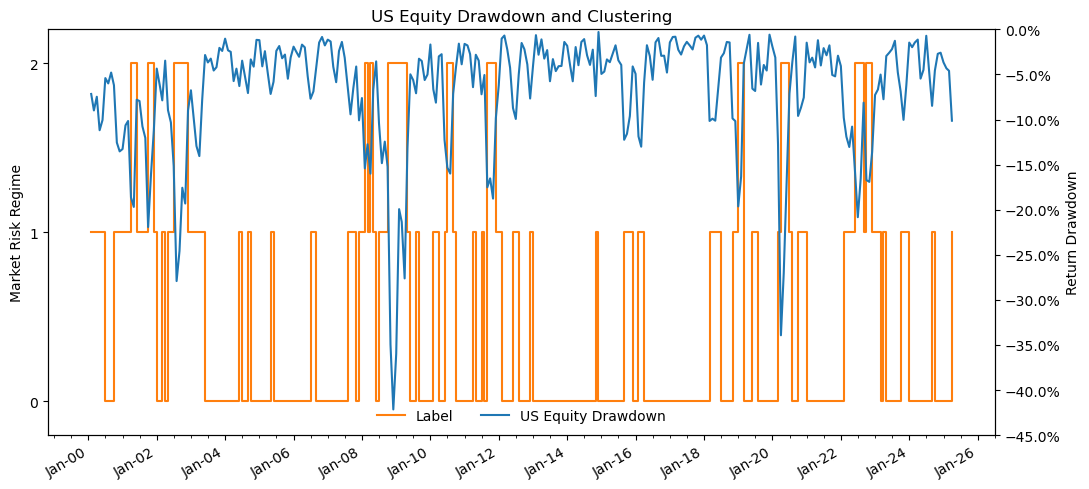

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# --- Align data (inner join on dates) ---
col = sp_3m_drawdown.columns[0]
df = (
    sp_3m_drawdown[[col]]
    .rename(columns={col: "drawdown"})
    .join(regimes[['regime']], how='inner')
    .dropna()
)

# --- Plot ---
fig, ax_left = plt.subplots(figsize=(11, 5))

# (1) Regime labels as a step plot on the LEFT y-axis (0/1/2)
ax_left.step(df.index, df['regime'], where='post', linewidth=1.5, color='tab:orange', label='Label')
ax_left.set_ylim(-0.2, 2.2)
ax_left.set_yticks([0, 1, 2])
ax_left.set_yticklabels(['0', '1', '2'])
ax_left.set_ylabel('Market Risk Regime')

# change the index of the x-axis
ax_left.xaxis.set_major_locator(YearLocator(2))
ax_left.xaxis.set_minor_locator(MonthLocator(bymonth=(1,7))) 
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))

# (2) Drawdown on the RIGHT y-axis (percent), often inverted (0% at top)
ax_right = ax_left.twinx()
ax_right.plot(df.index, df['drawdown'], linewidth=1.5, color='tab:blue', label='US Equity Drawdown')
ax_right.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax_right.set_ylabel('Return Drawdown')
# Optional: set a range like 0% to -45% and invert so 0% is at the top
lo = np.nanmin(df['drawdown'])
ax_right.set_ylim(0.0, min(-0.45, lo*1.05))  # cap around -45%
ax_right.invert_yaxis()

# Titles and legend
ax_left.set_title('US Equity Drawdown and Clustering')
ax_left.xaxis.set_major_formatter(DateFormatter('%b-%y'))
fig.autofmt_xdate()

# Build a single legend (take one handle from each axis)
h1, l1 = ax_left.get_legend_handles_labels()
h2, l2 = ax_right.get_legend_handles_labels()
ax_left.legend(h1 + h2, l1 + l2, loc='lower center', ncols=2, frameon=False)

plt.tight_layout()
plt.show()